# MASK DETECTION

In [1]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# parametreler
dataset_path = 'C:/Users/EXCALIBUR/Desktop/mask_proje'
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
IMG_SIZE = (224, 224)

# 1. --- Eğitim/Test Split Fonksiyonu ---
def create_train_test_split(source_path, train_ratio=0.8):
    train_dir = os.path.join(source_path, 'train')
    test_dir = os.path.join(source_path, 'test')
    if os.path.exists(train_dir): shutil.rmtree(train_dir)
    if os.path.exists(test_dir): shutil.rmtree(test_dir)
    for directory in [train_dir, test_dir]:
        for class_name in ['with_mask', 'without_mask']:
            os.makedirs(os.path.join(directory, class_name), exist_ok=True)
    for class_name in ['with_mask', 'without_mask']:
        class_path = os.path.join(source_path, class_name)
        if not os.path.exists(class_path):
            print(f"HATA: {class_path} klasörü bulunamadı!"); continue
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        if len(images) == 0:
            print(f"HATA: {class_name} klasörü boş!"); continue
        train_images, test_images = train_test_split(images, test_size=(1-train_ratio), random_state=42)
        for img in train_images:
            shutil.copy2(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in test_images:
            shutil.copy2(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))
        print(f"{class_name}: {len(train_images)} train, {len(test_images)} test")

print("Dataset organize ediliyor...")
create_train_test_split(dataset_path)
print("Dataset organizasyonu tamamlandı!")

train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

Dataset organize ediliyor...
with_mask: 2980 train, 745 test
without_mask: 3062 train, 766 test
Dataset organizasyonu tamamlandı!


In [3]:
# 2. --- Data Augmentation ve Generatorlar ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BS,
    class_mode='binary',
    classes=['with_mask', 'without_mask']
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BS,
    class_mode='binary',
    classes=['with_mask', 'without_mask']
)

print(f"\nEğitim örnekleri: {train_generator.samples}")
print(f"Doğrulama örnekleri: {validation_generator.samples}")
print(f"Sınıf indeksleri: {train_generator.class_indices}")

# 3. --- Transfer Learning Model ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary sınıflama!
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Found 6042 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.

Eğitim örnekleri: 6042
Doğrulama örnekleri: 1511
Sınıf indeksleri: {'with_mask': 0, 'without_mask': 1}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

C:\Users\EXCALIBUR\anaconda3\envs\new\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
 66/188 ━━━━━━━━━━━━━━━━━━━━ 2:52 1s/step - accuracy: 0.7085 - loss: 0.5567

C:\Users\EXCALIBUR\anaconda3\envs\new\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.8165 - loss: 0.3872 - val_accuracy: 0.9761 - val_loss: 0.0787
Epoch 2/20
  1/188 ━━━━━━━━━━━━━━━━━━━━ 1:52 599ms/step - accuracy: 1.0000 - loss: 0.0397

C:\Users\EXCALIBUR\anaconda3\envs\new\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


188/188 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 1.0000 - loss: 0.0397 - val_accuracy: 0.9761 - val_loss: 0.0787
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9693 - loss: 0.0794 - val_accuracy: 0.9827 - val_loss: 0.0566
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 146ms/step - accuracy: 0.9688 - loss: 0.0407 - val_accuracy: 0.9814 - val_loss: 0.0575
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 169s 896ms/step - accuracy: 0.9810 - loss: 0.0568 - val_accuracy: 0.9767 - val_loss: 0.0580
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.9688 - loss: 0.0846 - val_accuracy: 0.9774 - val_loss: 0.0572
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 146s 777ms/step - accuracy: 0.9831 - loss: 0.0488 - val_accuracy: 0.9860 - val_loss: 0.0462
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 130ms/step - accuracy: 0.9688 - loss: 0.0552 - val_accuracy: 0.9867 - val_loss: 0.0459
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 147s 781ms/step - accuracy: 0.9852 - loss: 0.0436 - va

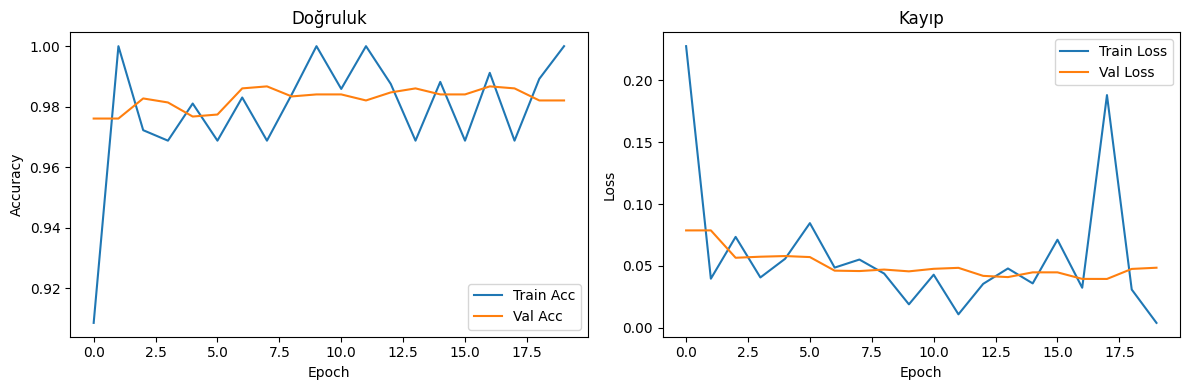

48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 482ms/step - accuracy: 0.9848 - loss: 0.0455
Test Loss: 0.0483
Test Accuracy: 0.9821 (98.21%)
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 499ms/step

📊 DETAYLI SINIFLANDIRMA RAPORU:
              precision    recall  f1-score   support

   with_mask       0.50      0.51      0.50       745
without_mask       0.51      0.50      0.50       766

    accuracy                           0.50      1511
   macro avg       0.50      0.50      0.50      1511
weighted avg       0.50      0.50      0.50      1511



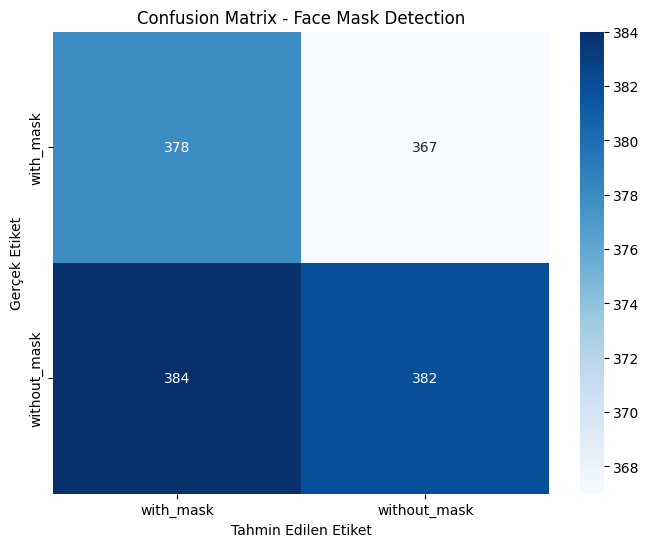


🔍 CONFUSION MATRIX ANALİZİ:
With Mask Doğru Tahmin: 378
With Mask Yanlış Tahmin: 367
Without Mask Doğru Tahmin: 382
Without Mask Yanlış Tahmin: 384

With Mask Sınıf Doğruluğu: 50.74%
Without Mask Sınıf Doğruluğu: 49.87%


In [5]:
# 4. --- Eğitim ---
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BS,
    epochs=EPOCHS
)

model.save('mask_detector.keras')
print("Model başarıyla kaydedildi!")

# 5. --- Eğitim Grafikleri ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Doğruluk')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Kayıp')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# --- Değerlendirme ve Metrikler ---
model = load_model('mask_detector.keras')
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
validation_generator.reset()
predictions = model.predict(validation_generator, verbose=1)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print("\n📊 DETAYLI SINIFLANDIRMA RAPORU:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Face Mask Detection')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

print("\n🔍 CONFUSION MATRIX ANALİZİ:")
print(f"With Mask Doğru Tahmin: {cm[0,0]}")
print(f"With Mask Yanlış Tahmin: {cm[0,1]}")
print(f"Without Mask Doğru Tahmin: {cm[1,1]}")
print(f"Without Mask Yanlış Tahmin: {cm[1,0]}")

with_mask_accuracy = cm[0,0] / (cm[0,0] + cm[0,1]) * 100
without_mask_accuracy = cm[1,1] / (cm[1,1] + cm[1,0]) * 100
print(f"\nWith Mask Sınıf Doğruluğu: {with_mask_accuracy:.2f}%")
print(f"Without Mask Sınıf Doğruluğu: {without_mask_accuracy:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step


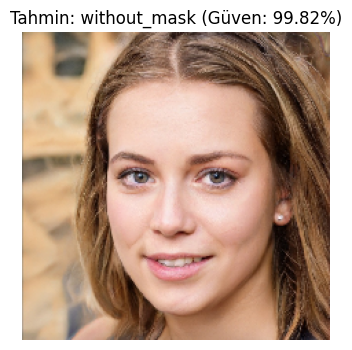

Tahmin: without_mask
Güven Oranı: 99.82%
With Mask Olasılığı: 0.18%
Without Mask Olasılığı: 99.82%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


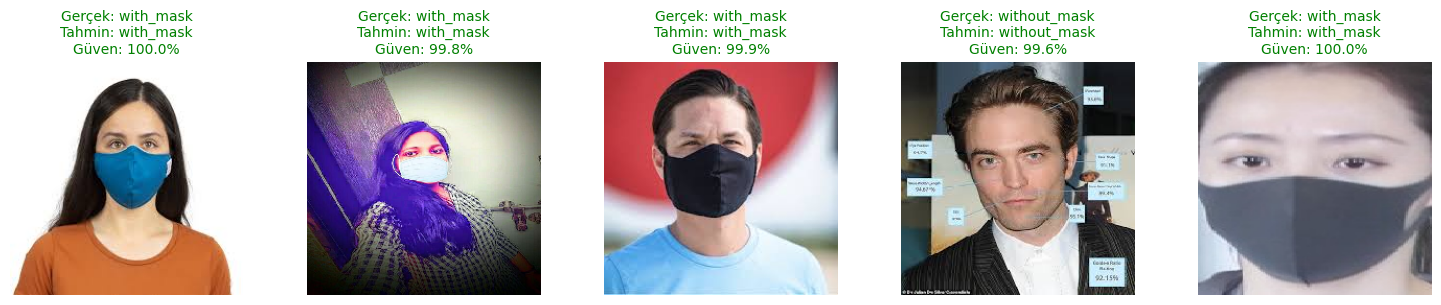

In [11]:
# 6. --- Örnek Görsel Tahminleri ---
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def test_single_image(image_path, model):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    prediction = model.predict(img_array)
    class_names = ['with_mask', 'without_mask']
    predicted_class = int(prediction[0][0] > 0.5)
    confidence = prediction[0][0] if predicted_class == 1 else 1 - prediction[0][0]
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f'Tahmin: {class_names[predicted_class]} (Güven: {confidence*100:.2f}%)')
    plt.axis('off')
    plt.show()
    print(f"Tahmin: {class_names[predicted_class]}")
    print(f"Güven Oranı: {confidence*100:.2f}%")
    print(f"With Mask Olasılığı: {(1-prediction[0][0])*100:.2f}%")
    print(f"Without Mask Olasılığı: {prediction[0][0]*100:.2f}%")

test_single_image('resim.jpg', model)

def display_random_test_results(validation_generator, model, num_images=5):
    validation_generator.reset()
    images, labels = next(validation_generator)
    actual_num_images = min(num_images, len(images))
    predictions = model.predict(images[:actual_num_images])
    class_names = ['with_mask', 'without_mask']
    plt.figure(figsize=(15, 3))
    for i in range(actual_num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        true_label = class_names[int(labels[i])]
        pred_label = class_names[int(predictions[i][0] > 0.5)]
        confidence = predictions[i][0] if pred_label=='without_mask' else 1-predictions[i][0]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f'Gerçek: {true_label}\nTahmin: {pred_label}\nGüven: {confidence*100:.1f}%', 
                 color=color, fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_random_test_results(validation_generator, model, num_images=5)

## ResNet50 

In [3]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# parametreler
dataset_path = 'C:/Users/EXCALIBUR/Desktop/mask_proje'
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
IMG_SIZE = (224, 224)

# 1. --- Eğitim/Test Split Fonksiyonu ---
def create_train_test_split(source_path, train_ratio=0.8):
    train_dir = os.path.join(source_path, 'train')
    test_dir = os.path.join(source_path, 'test')
    if os.path.exists(train_dir): shutil.rmtree(train_dir)
    if os.path.exists(test_dir): shutil.rmtree(test_dir)
    for directory in [train_dir, test_dir]:
        for class_name in ['with_mask', 'without_mask']:
            os.makedirs(os.path.join(directory, class_name), exist_ok=True)
    for class_name in ['with_mask', 'without_mask']:
        class_path = os.path.join(source_path, class_name)
        if not os.path.exists(class_path):
            print(f"HATA: {class_path} klasörü bulunamadı!"); continue
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        if len(images) == 0:
            print(f"HATA: {class_name} klasörü boş!"); continue
        train_images, test_images = train_test_split(images, test_size=(1-train_ratio), random_state=42)
        for img in train_images:
            shutil.copy2(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in test_images:
            shutil.copy2(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))
        print(f"{class_name}: {len(train_images)} train, {len(test_images)} test")

print("Dataset organize ediliyor...")
create_train_test_split(dataset_path)
print("Dataset organizasyonu tamamlandı!")

train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

Dataset organize ediliyor...
with_mask: 2980 train, 745 test
without_mask: 3062 train, 766 test
Dataset organizasyonu tamamlandı!


In [5]:
# 2. --- Data Augmentation ve Generatorlar ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BS,
    class_mode='binary',
    classes=['with_mask', 'without_mask']
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BS,
    class_mode='binary',
    classes=['with_mask', 'without_mask']
)

print(f"\nEğitim örnekleri: {train_generator.samples}")
print(f"Doğrulama örnekleri: {validation_generator.samples}")
print(f"Sınıf indeksleri: {train_generator.class_indices}")

# 3. --- Transfer Learning Model ---
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary sınıflama!
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Found 6042 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.

Eğitim örnekleri: 6042
Doğrulama örnekleri: 1511
Sınıf indeksleri: {'with_mask': 0, 'without_mask': 1}
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

C:\Users\EXCALIBUR\anaconda3\envs\new\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
  2/188 ━━━━━━━━━━━━━━━━━━━━ 6:01 2s/step - accuracy: 0.4922 - loss: 0.8054  

C:\Users\EXCALIBUR\anaconda3\envs\new\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.4984 - loss: 0.7477 - val_accuracy: 0.5971 - val_loss: 0.6696
Epoch 2/20
  1/188 ━━━━━━━━━━━━━━━━━━━━ 4:08 1s/step - accuracy: 0.5938 - loss: 0.6584

C:\Users\EXCALIBUR\anaconda3\envs\new\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


188/188 ━━━━━━━━━━━━━━━━━━━━ 67s 353ms/step - accuracy: 0.5938 - loss: 0.6584 - val_accuracy: 0.5964 - val_loss: 0.6696
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.5717 - loss: 0.6766 - val_accuracy: 0.6057 - val_loss: 0.6625
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 67s 350ms/step - accuracy: 0.6250 - loss: 0.6334 - val_accuracy: 0.6057 - val_loss: 0.6626
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.6034 - loss: 0.6662 - val_accuracy: 0.6057 - val_loss: 0.6583
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 67s 351ms/step - accuracy: 0.5625 - loss: 0.6781 - val_accuracy: 0.6031 - val_loss: 0.6585
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.5984 - loss: 0.6650 - val_accuracy: 0.6004 - val_loss: 0.6671
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 67s 353ms/step - accuracy: 0.5312 - loss: 0.7181 - val_accuracy: 0.6077 - val_loss: 0.6641
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.6135 - loss: 0.6594 - val_accurac

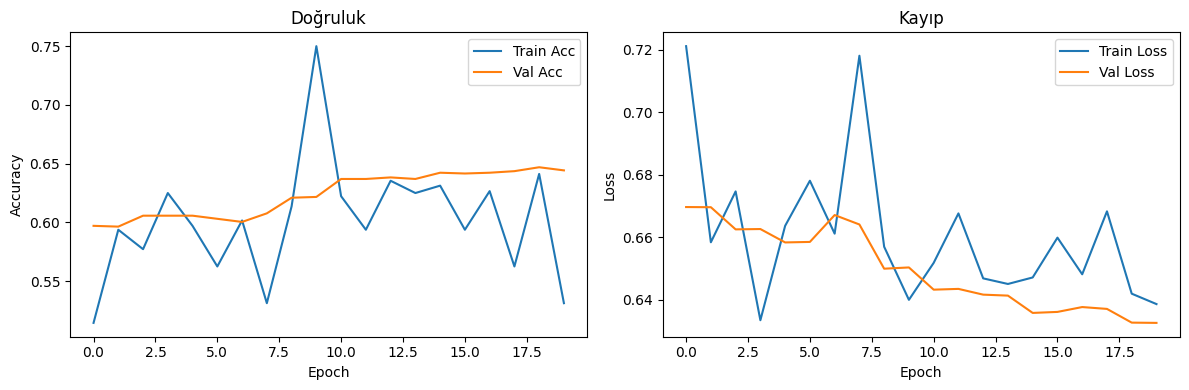

48/48 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.6124 - loss: 0.6425
Test Loss: 0.6327
Test Accuracy: 0.6439 (64.39%)
48/48 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step

📊 DETAYLI SINIFLANDIRMA RAPORU:
              precision    recall  f1-score   support

   with_mask       0.49      0.31      0.38       745
without_mask       0.50      0.69      0.58       766

    accuracy                           0.50      1511
   macro avg       0.49      0.50      0.48      1511
weighted avg       0.50      0.50      0.48      1511



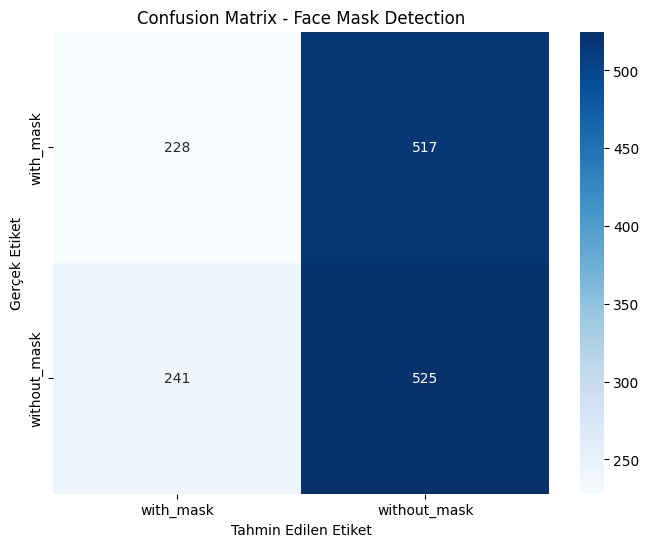


🔍 CONFUSION MATRIX ANALİZİ:
With Mask Doğru Tahmin: 228
With Mask Yanlış Tahmin: 517
Without Mask Doğru Tahmin: 525
Without Mask Yanlış Tahmin: 241

With Mask Sınıf Doğruluğu: 30.60%
Without Mask Sınıf Doğruluğu: 68.54%


In [7]:
# 4. --- Eğitim ---
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BS,
    epochs=EPOCHS
)

model.save('mask_detector.keras')
print("Model başarıyla kaydedildi!")

# 5. --- Eğitim Grafikleri ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Doğruluk')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Kayıp')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# --- Değerlendirme ve Metrikler ---
model = load_model('mask_detector.keras')
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
validation_generator.reset()
predictions = model.predict(validation_generator, verbose=1)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print("\n📊 DETAYLI SINIFLANDIRMA RAPORU:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Face Mask Detection')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

print("\n🔍 CONFUSION MATRIX ANALİZİ:")
print(f"With Mask Doğru Tahmin: {cm[0,0]}")
print(f"With Mask Yanlış Tahmin: {cm[0,1]}")
print(f"Without Mask Doğru Tahmin: {cm[1,1]}")
print(f"Without Mask Yanlış Tahmin: {cm[1,0]}")

with_mask_accuracy = cm[0,0] / (cm[0,0] + cm[0,1]) * 100
without_mask_accuracy = cm[1,1] / (cm[1,1] + cm[1,0]) * 100
print(f"\nWith Mask Sınıf Doğruluğu: {with_mask_accuracy:.2f}%")
print(f"Without Mask Sınıf Doğruluğu: {without_mask_accuracy:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


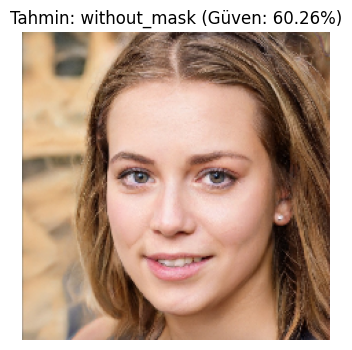

Tahmin: without_mask
Güven Oranı: 60.26%
With Mask Olasılığı: 39.74%
Without Mask Olasılığı: 60.26%
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


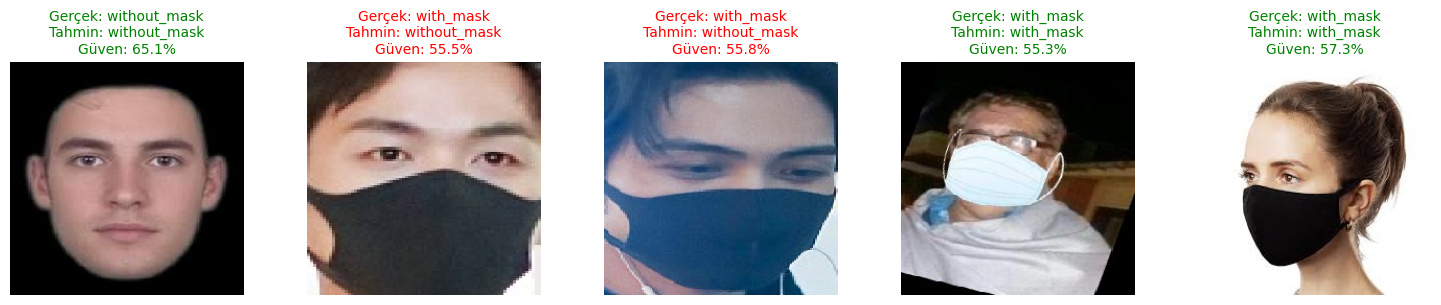

In [9]:
# 6. --- Örnek Görsel Tahminleri ---
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def test_single_image(image_path, model):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    prediction = model.predict(img_array)
    class_names = ['with_mask', 'without_mask']
    predicted_class = int(prediction[0][0] > 0.5)
    confidence = prediction[0][0] if predicted_class == 1 else 1 - prediction[0][0]
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f'Tahmin: {class_names[predicted_class]} (Güven: {confidence*100:.2f}%)')
    plt.axis('off')
    plt.show()
    print(f"Tahmin: {class_names[predicted_class]}")
    print(f"Güven Oranı: {confidence*100:.2f}%")
    print(f"With Mask Olasılığı: {(1-prediction[0][0])*100:.2f}%")
    print(f"Without Mask Olasılığı: {prediction[0][0]*100:.2f}%")

test_single_image('resim.jpg', model)

def display_random_test_results(validation_generator, model, num_images=5):
    validation_generator.reset()
    images, labels = next(validation_generator)
    actual_num_images = min(num_images, len(images))
    predictions = model.predict(images[:actual_num_images])
    class_names = ['with_mask', 'without_mask']
    plt.figure(figsize=(15, 3))
    for i in range(actual_num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        true_label = class_names[int(labels[i])]
        pred_label = class_names[int(predictions[i][0] > 0.5)]
        confidence = predictions[i][0] if pred_label=='without_mask' else 1-predictions[i][0]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f'Gerçek: {true_label}\nTahmin: {pred_label}\nGüven: {confidence*100:.1f}%', 
                 color=color, fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_random_test_results(validation_generator, model, num_images=5)

# İyileştirilmiş MobileNetV2

Dataset organize ediliyor...
with_mask: 2980 train, 745 test
without_mask: 3062 train, 766 test
Dataset organizasyonu tamamlandı!
Found 6042 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.

Eğitim örnekleri: 6042
Doğrulama örnekleri: 1511
Sınıf indeksleri: {'with_mask': 0, 'without_mask': 1}


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,620,481 (10.00 MB)

 Trainable params: 361,729 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

C:\Users\EXCALIBUR\anaconda3\envs\new\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
 22/188 ━━━━━━━━━━━━━━━━━━━━ 2:27 889ms/step - accuracy: 0.5940 - loss: 0.7993

C:\Users\EXCALIBUR\anaconda3\envs\new\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.7652 - loss: 0.4929
Epoch 1: val_loss improved from inf to 0.09418, saving model to best_mobilenetv2.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.7657 - loss: 0.4920 - val_accuracy: 0.9734 - val_loss: 0.0942 - learning_rate: 1.0000e-04
Epoch 2/40
  1/188 ━━━━━━━━━━━━━━━━━━━━ 1:31 487ms/step - accuracy: 0.9375 - loss: 0.2063

C:\Users\EXCALIBUR\anaconda3\envs\new\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.09418 to 0.09365, saving model to best_mobilenetv2.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 126ms/step - accuracy: 0.9375 - loss: 0.2063 - val_accuracy: 0.9734 - val_loss: 0.0937 - learning_rate: 1.0000e-04
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.9355 - loss: 0.1740
Epoch 3: val_loss improved from 0.09365 to 0.05844, saving model to best_mobilenetv2.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 151s 804ms/step - accuracy: 0.9356 - loss: 0.1739 - val_accuracy: 0.9801 - val_loss: 0.0584 - learning_rate: 1.0000e-04
Epoch 4/40
  1/188 ━━━━━━━━━━━━━━━━━━━━ 1:32 497ms/step - accuracy: 0.8750 - loss: 0.1625
Epoch 4: val_loss improved from 0.05844 to 0.05823, saving model to best_mobilenetv2.keras
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 126ms/step - accuracy: 0.8750 - loss: 0.1625 - val_accuracy: 0.9807 - val_loss: 0.0582 - learning_rate: 1.0000e-04
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9511 - loss: 0.1289
Epoch 5: val_lo

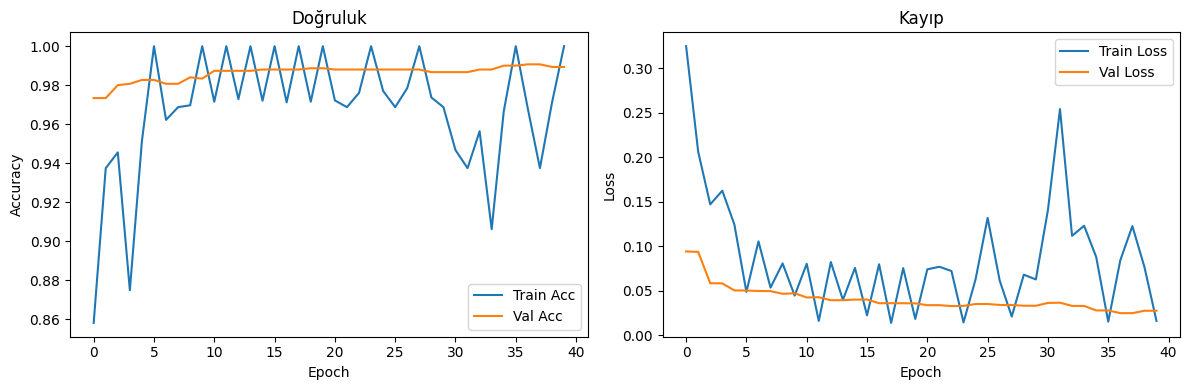

48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 481ms/step - accuracy: 0.9918 - loss: 0.0201
Test Loss: 0.0247
Test Accuracy: 0.9907 (99.07%)
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 512ms/step

 DETAYLI SINIFLANDIRMA RAPORU:
              precision    recall  f1-score   support

   with_mask       0.50      0.51      0.50       745
without_mask       0.52      0.51      0.52       766

    accuracy                           0.51      1511
   macro avg       0.51      0.51      0.51      1511
weighted avg       0.51      0.51      0.51      1511



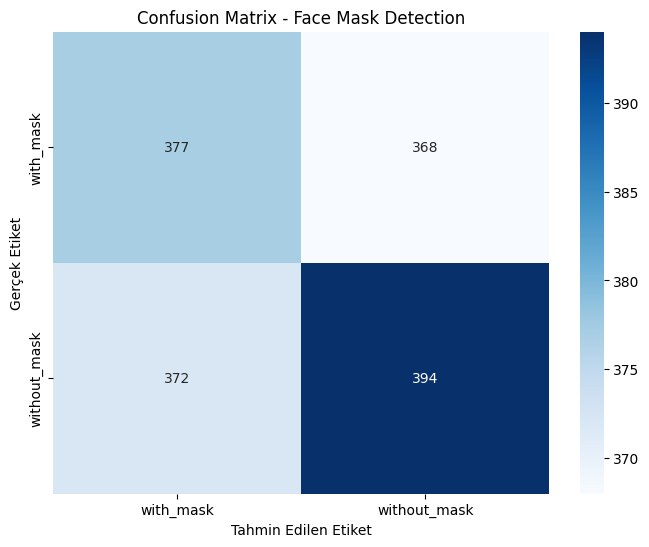

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


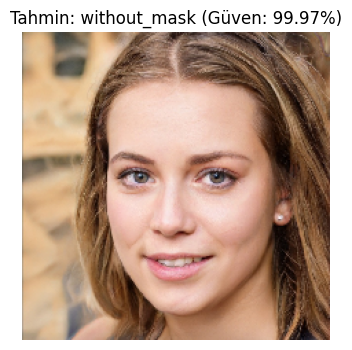

Tahmin: without_mask
Güven Oranı: 99.97%
With Mask Olasılığı: 0.03%
Without Mask Olasılığı: 99.97%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


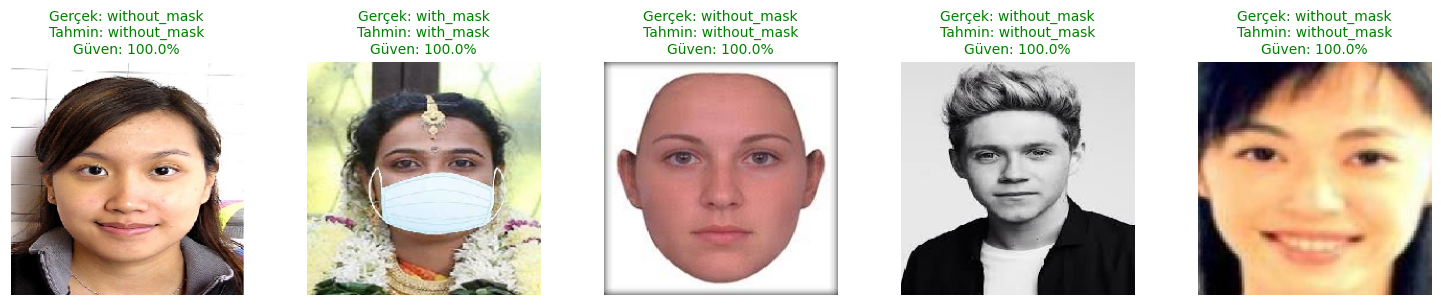

In [9]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. Temel parametreler
dataset_path = 'C:/Users/EXCALIBUR/Desktop/mask_proje'
INIT_LR = 1e-4
EPOCHS = 40
BS = 32
IMG_SIZE = (224, 224)

# 2. Eğitim/Test Split
def create_train_test_split(source_path, train_ratio=0.8):
    train_dir = os.path.join(source_path, 'train')
    test_dir = os.path.join(source_path, 'test')
    if os.path.exists(train_dir): shutil.rmtree(train_dir)
    if os.path.exists(test_dir): shutil.rmtree(test_dir)
    for directory in [train_dir, test_dir]:
        for class_name in ['with_mask', 'without_mask']:
            os.makedirs(os.path.join(directory, class_name), exist_ok=True)
    for class_name in ['with_mask', 'without_mask']:
        class_path = os.path.join(source_path, class_name)
        if not os.path.exists(class_path):
            print(f"HATA: {class_path} klasörü bulunamadı!"); continue
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        if len(images) == 0:
            print(f"HATA: {class_name} klasörü boş!"); continue
        train_images, test_images = train_test_split(images, test_size=(1-train_ratio), random_state=42)
        for img in train_images:
            shutil.copy2(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in test_images:
            shutil.copy2(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))
        print(f"{class_name}: {len(train_images)} train, {len(test_images)} test")

print("Dataset organize ediliyor...")
create_train_test_split(dataset_path)
print("Dataset organizasyonu tamamlandı!")

train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

# 3. Veri Artırma güçlü augmentation ile
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BS,
    class_mode='binary',
    classes=['with_mask', 'without_mask']
)
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BS,
    class_mode='binary',
    classes=['with_mask', 'without_mask']
)

print(f"\nEğitim örnekleri: {train_generator.samples}")
print(f"Doğrulama örnekleri: {validation_generator.samples}")
print(f"Sınıf indeksleri: {train_generator.class_indices}")

# 4.Modelin üst katmanlarını zenginleştir & transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR),
              loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# 5. Eğitim Stratejisi: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
early = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint("best_mobilenetv2.keras", monitor="val_loss", save_best_only=True, verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BS,
    epochs=EPOCHS,
    callbacks=[early, lr_reduce, checkpoint]
)

# 6. Fine-tuning: son 20 katman açılır, düşük lr ile yeniden eğitim
base_model.trainable = True
for layer in base_model.layers[:-20]:  
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BS,
    epochs=10,
    callbacks=[early, lr_reduce, checkpoint]
)

# 7. En iyi modeli yükle 
model = load_model('best_mobilenetv2.keras')

# 8. Eğitim & Doğrulama grafikleri
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy']+history_fine.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy']+history_fine.history['val_accuracy'], label='Val Acc')
plt.title('Doğruluk')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss']+history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss']+history_fine.history['val_loss'], label='Val Loss')
plt.title('Kayıp')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 9. Değerlendirme ve metrikler
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
validation_generator.reset()
predictions = model.predict(validation_generator, verbose=1)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print("\n DETAYLI SINIFLANDIRMA RAPORU:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Face Mask Detection')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

# 10. Örnek görsel tahmin fonksiyonları
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def test_single_image(image_path, model):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    prediction = model.predict(img_array)
    class_names = ['with_mask', 'without_mask']
    predicted_class = int(prediction[0][0] > 0.5)
    confidence = prediction[0][0] if predicted_class == 1 else 1 - prediction[0][0]
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f'Tahmin: {class_names[predicted_class]} (Güven: {confidence*100:.2f}%)')
    plt.axis('off')
    plt.show()
    print(f"Tahmin: {class_names[predicted_class]}")
    print(f"Güven Oranı: {confidence*100:.2f}%")
    print(f"With Mask Olasılığı: {(1-prediction[0][0])*100:.2f}%")
    print(f"Without Mask Olasılığı: {prediction[0][0]*100:.2f}%")
test_single_image("resim.jpg", model)

def display_random_test_results(validation_generator, model, num_images=5):
    validation_generator.reset()
    images, labels = next(validation_generator)
    actual_num_images = min(num_images, len(images))
    predictions = model.predict(images[:actual_num_images])
    class_names = ['with_mask', 'without_mask']
    plt.figure(figsize=(15, 3))
    for i in range(actual_num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        true_label = class_names[int(labels[i])]
        pred_label = class_names[int(predictions[i][0] > 0.5)]
        confidence = predictions[i][0] if pred_label == 'without_mask' else 1 - predictions[i][0]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f'Gerçek: {true_label}\nTahmin: {pred_label}\nGüven: {confidence*100:.1f}%'
                 , color=color, fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_random_test_results(validation_generator, model, num_images=5)
